In [1]:
import pandas as pd
import numpy as np

## Data Exploration

In this section we will explore the data to find and clean the data if necesarry. 

In [2]:
cust = pd.read_csv('customer_interactions.csv')
print("customer_interactions dimension ==> ",cust.shape)
print("customer_interactions duplication ==> ",cust.duplicated().sum())

cust

customer_interactions dimension ==>  (5, 3)
customer_interactions duplication ==>  0


,customer_id,page_views,time_spent
0,1,25,120
1,2,20,90
2,3,30,150
3,4,15,80
4,5,22,110


In [3]:
prod = pd.read_csv('product_details.csv', sep = ';')
print("product_details dimension ==> ",prod.shape)
print("product_details duplication ==> ",prod.duplicated().sum())

prod

product_details dimension ==>  (5, 7)
product_details duplication ==>  0


,product_id,category,price,ratings,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,101,Electronics,500,4.5,NaN,NaN,NaN
1,102,Clothing,50,3.8,NaN,NaN,NaN
2,103,Home & Kitchen,200,4.2,NaN,NaN,NaN
3,104,Beauty,30,4.0,NaN,NaN,NaN
4,105,Electronics,800,4.8,NaN,NaN,NaN


In [4]:
hist = pd.read_csv('purchase_history.csv', sep = ';')
print("purchase_history dimension ==> ",hist.shape)
print("purchase_history duplication ==> ",hist.duplicated().sum())

hist

purchase_history dimension ==>  (6, 7)
purchase_history duplication ==>  0


,customer_id,product_id,purchase_date,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,1,101,2023-01-01,NaN,NaN,NaN,NaN
1,1,105,2023-01-05,NaN,NaN,NaN,NaN
2,2,102,2023-01-02,NaN,NaN,NaN,NaN
3,3,103,2023-01-03,NaN,NaN,NaN,NaN
4,4,104,2023-01-04,NaN,NaN,NaN,NaN
5,5,101,2023-01-05,NaN,NaN,NaN,NaN


We can see that there are no duplication in the data, and no missing value important columns. However, in the  **product_details** and **purchase_history** data there are unnecessary columns. Then we remove it using this code.

In [5]:
hist = hist.dropna(how='all', axis=1)
hist.head()

,customer_id,product_id,purchase_date
0,1,101,2023-01-01
1,1,105,2023-01-05
2,2,102,2023-01-02
3,3,103,2023-01-03
4,4,104,2023-01-04


In [6]:
prod = prod.dropna(how='all', axis=1)
prod.head()

,product_id,category,price,ratings
0,101,Electronics,500,4.5
1,102,Clothing,50,3.8
2,103,Home & Kitchen,200,4.2
3,104,Beauty,30,4.0
4,105,Electronics,800,4.8


We remove the unwanted columns, however we have another problem which is the record number. To build a recommendation engine we need more data to mechine for learning the customer behaviour. Since we have only 5 transaction, it is not enough to make a recommendation engine. Therefore, I decide to modify the dataset by adding 30 the random transaction then save the result into the new file named *purchase_history_modify.csv* using the following code:

``` python
from faker import Faker
from datetime import date
from random import randint,seed

hist = pd.read_csv('purchase_history.csv', sep = ';')


seed(2710)
fake = Faker()

dt = []
for i in range(30):
    dd = fake.date_between(date(2023, 1, 7), end_date=date(2023, 3, 10))
    
    dt.append(dd.strftime('%Y-%m-%d'))

userid = []
for i in range(30):
    userid.append(randint(1, 5))


prodid = []
for i in range(30):
    prodid.append(randint(101, 105))

d_sim = pd.DataFrame({'customer_id': userid, 'product_id': prodid, 'purchase_date': dt})


df_mod = pd.concat([hist, d_sim], ignore_index = True).sort_values('product_id')


df_mod.to_csv('purchase_history_modify.csv')

```

<Axes: xlabel='customer_id', ylabel='number of transaction'>

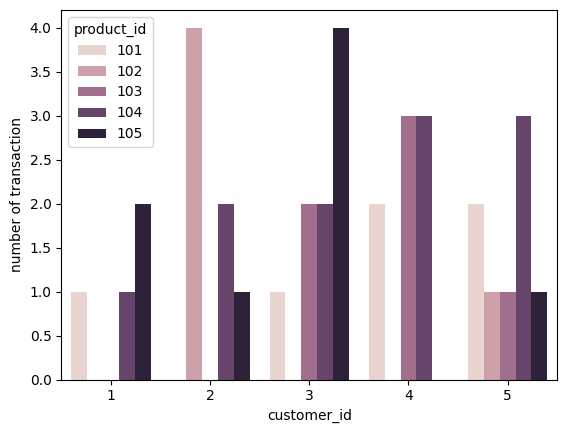

In [22]:
import seaborn as sns
hist = pd.read_csv('purchase_history_modify.csv')

hist_agg = hist.groupby(['customer_id', 'product_id']).size().reset_index()
hist_agg.rename(columns = {0:'number of transaction'}, inplace = True)
hist_agg
sns.barplot(x = 'customer_id', y = 'number of transaction', hue = 'product_id', data = hist_agg)

After modifiying the data we can see that the transactions more vary compared to the unmodified data. With this data we can continue to build a recommendation engine.

 ## Building recommendation engine

Since we have a limited resouce and time, I will created a recommendation engine using Colaborative filtering. it is a technique that can filter out items that a user might like on the basis of reactions by similar users. It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user. It looks at the items they like and combines them to create a ranked list of suggestions.

There are many AI or machine learning model that can make a recommendation engine, we use this method because its simplicity and it takes less resource to work with compared to other method. This method also proven useful by many big tech company such as Amazon and Netflix. We also utilize the KNN (*K Nearest Neighbor*), It works by finding the K nearest points in the training dataset and uses their class to predict the class or value of a new data point. 


The first things the we need to do is to build matrix of a reaction of Customer_Id to the Product_Id. The reaction can be *explicit* (rating on a scale of 1 to 5, likes or dislikes) or *implicit* (viewing an item, adding it to a wish list, the time spent on an article). Since we do not have the rating that are linked to the customer_id directly, therefore, we use implicit by comparing the number of purched of product by the customer.

We build a matrix like as follow, with *u* is the customer_id and *i* is the product id. We can use pandas function *pivot* to build that matrix. 

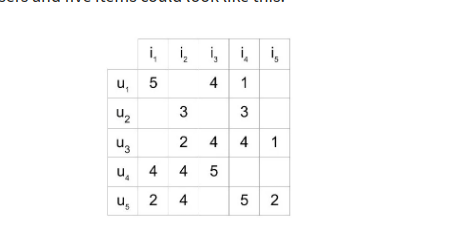


After the matrix was build, we will create feature X  and the target Y. Before we run the KNN we transform the X into X-mean(X). The Idea is we loop through every items and customers, and predict the number of transaction of user a and item 1 based on the behaviour of other users. The code are available as follow:

``` python
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd

def recommendation_eng(df):
    to_knn = df.groupby(['customer_id', 'product_id'])['purchase_date'].count().reset_index().pivot(index = 'customer_id', 
                                                                                             columns= 'product_id',  values = 'purchase_date')

    # Get the average rating for each user 
    avg_ratings = to_knn.mean(axis=1)

    # Center each users ratings around 0
    user_ratings_table_centered = to_knn.apply(lambda x: x-avg_ratings, axis=0)

    # Fill in the missing data with 0s
    to_knn_fill = user_ratings_table_centered.fillna(0)

    prod_l = []
    usr_l = []
    pred_l = []
    for i in [101, 102, 103, 104, 105]:
        for j in range(1, 6, 1):
            df_knn = to_knn_fill.drop(i, axis=1)
            target_user_x = df_knn.loc[[j]]
            other_users_y = to_knn[i]

            other_users_x = df_knn[other_users_y.notnull()]
            other_users_y.dropna(inplace=True)

            # Instantiate the user KNN model
            user_knn = KNeighborsRegressor(metric='cosine', n_neighbors= 2)

            # Fit the model and predict the target user
            user_knn.fit(other_users_x, other_users_y)
            user_user_pred = user_knn.predict(target_user_x)
            prod_l.append(i)
            usr_l.append(j)
            pred_l.append(user_user_pred[0])

    df_pred = pd.DataFrame({'product_id':prod_l, 'customer_id':usr_l, 'buy_prediction': pred_l})

    #piv_pred = df_pred.pivot(index = 'customer_id', columns= 'product_id', values= 'buy_prediction')
    
    return df_pred

```

## Model Evaluation

Since we do not have many data, so we can not split the data into *testing* and *train* set. Alternatively, we can just evaluate the training set. We evaluate the model using Mean Squared Error and obtain the score is 0.6528 which quite good. The code for the evaluatation is as follow:

``` python

from model_rec import  recommendation_eng
from sklearn.metrics import mean_squared_error

hist = pd.read_csv('purchase_history_modify.csv')

df_pred = recommendation_eng(hist)

piv_pred = df_pred.pivot(index = 'customer_id', columns= 'product_id', values= 'buy_prediction').values

to_knn = hist.groupby(['customer_id', 'product_id'])['purchase_date'].count().reset_index().pivot(index = 'customer_id', 
                         columns= 'product_id',  values = 'purchase_date').values
mask = ~np.isnan(to_knn)

mean_squared_error( to_knn[mask], piv_pred[mask])

## 0.6527777777777778

```

## Web application

In this case I am using *shiny* from posit.co (formerly Rstudio), shiny is web application that provided for R. However, lately they support the package for Python. I am using this because the ease of use as well as they provide free deployment for the web application.

Here is the explanation of the file in this repository:

* **app.py** : The core of web application code, it contains of code that manage the UI and the server of the web application
* **icon.py** : The supportive file that contain SVG for the icon
* **model_rec.py** : The code of the recommendation engine
* **requirements.txt** : python package that are required to be installed

The code are available in this github link

https://github.com/zaenalium/skillvul-test.git

### How to run this code.

in order to run this code make sure you are using python version 3.9.16 or latest. Then install the package requirements by typing this command.

```
git clone https://github.com/zaenalium/skillvul-test.git

cd skillvul-test
pip install -r requirements.txt
```


After install all the requirements, then we can start running the main code by using this command 


```
## make sure you are still in the same directory same as the command above

shiny run --reload --launch-browser app.py 

```

Then open the browser visit this address http://127.0.0.1:8000/.  Then you will get the web application as follow:

![screenshot of the web application](image.png)

Please input the Customer Id for the selected Id that use want to check, and input the "Number of Recommendation" for how many of the recommendations. Please be noted, since we only have 5 users. The Id that allowed input is only 1, 2, 3, 4 and 5, and the recommendation also have maximum 5 number of recommended product.

## Deployment

I deployed the code to the https://www.shinyapps.io/. However, there was an error in the host. Thus, in the end I deployed it locally. The web application that I made can be accessed in this following link

<H1>https://74d6-103-47-132-15.ngrok-free.app</H1>